In [2]:
# Parameters — edit to test different scenarios
battery_kwh = 60.0               # usable battery capacity in kWh
consumption_kwh_per_km = 0.15    # baseline consumption in kWh per km
max_distance_km = 500            # maximum simulated distance (km)
step_km = 1                      # resolution (km)

# Charging stops: list of (km_location, charge_to_percent)
# Example: one fast charge at 200 km that charges to 80% SOC
charge_stops = [
    (200, 80),   # (distance_km, target_SOC_percent)
    # (350, 90)  # add more stops if needed
]

# Regenerative braking (simple model)
use_regen = True
regen_recovery_fraction = 0.10   # fraction of energy recovered for 'city' segments (10% recovered)
# If regen is used, we apply it as a percentage reduction on consumption where flagged below.

# Optional: define segments with different consumption (start_km, end_km, consumption_kwh_per_km)
# Example: city segment from 0-50 km with more stop-start (regen applies), highway rest
consumption_profile = [
    (0, 50, 0.14),    # start_km, end_km, consumption_kwh_per_km (city-ish)
    (50, max_distance_km, 0.16)  # highway-ish (higher consumption)
]
# If consumption_profile is empty, the code will use consumption_kwh_per_km for all distances.


In [3]:
import numpy as np

# Build distance array
dist_km = np.arange(0, max_distance_km + step_km, step_km)

# Build consumption per-km array from profile (fallback to baseline)
cons_per_km = np.full_like(dist_km, consumption_kwh_per_km, dtype=float)

if 'consumption_profile' in globals() and len(consumption_profile) > 0:
    for (start_km, end_km, cons_val) in consumption_profile:
        start_idx = int(start_km / step_km)
        end_idx = int(min(end_km, max_distance_km) / step_km) + 1
        cons_per_km[start_idx:end_idx] = cons_val

# Apply a simple regen model by reducing net consumption on segments where it matters
# Here we approximate regen as a fraction recovery subtracted from consumption where use_regen is True.
# In real models, regen depends on driving pattern, braking events, and speed profiles.
if use_regen and regen_recovery_fraction > 0:
    # For demonstration, apply regen only to segments where consumption is <= baseline (assumed city)
    baseline = consumption_kwh_per_km
    regen_mask = cons_per_km <= baseline
    cons_per_km[regen_mask] = np.maximum(cons_per_km[regen_mask] * (1 - regen_recovery_fraction), 0.0)

# Energy used cumulative
energy_used_kwh = np.cumsum(cons_per_km) * step_km

# Remaining energy without charging (kWh)
remaining_kwh = np.maximum(battery_kwh - energy_used_kwh, 0.0)

# Function to apply a charging stop (modifies remaining_kwh in place)
def apply_charge_stop(remaining_array, stop_idx, target_percent, battery_capacity):
    """
    remaining_array: numpy array of remaining kWh at each distance
    stop_idx: integer index in the distance array where charging happens
    target_percent: desired SOC after charging (0-100)
    battery_capacity: usable battery capacity (kWh)
    """
    current_kwh = remaining_array[stop_idx]
    target_kwh = battery_capacity * (target_percent / 100.0)
    if current_kwh >= target_kwh:
        # Already above target; no charging needed
        return remaining_array
    # energy to add to reach target
    delta = target_kwh - current_kwh
    # add delta to remaining energy from stop index onward, ensuring we do not exceed battery capacity
    remaining_array[stop_idx:] = np.minimum(remaining_array[stop_idx:] + delta, battery_capacity)
    return remaining_array

# Apply charge stops in chronological order
if len(charge_stops) > 0:
    for (stop_km, target_percent) in sorted(charge_stops, key=lambda x: x[0]):
        if stop_km < 0 or stop_km > max_distance_km:
            continue
        idx = int(stop_km / step_km)
        remaining_kwh = apply_charge_stop(remaining_kwh, idx, target_percent, battery_kwh)
        # After charging, update energy_used_kwh so that remaining_kwh remains consistent if needed:
        # (Here we keep remaining_kwh as ground truth and compute battery_percent from it)

# Battery percentage
battery_percent = (remaining_kwh / battery_kwh) * 100.0

# Print some sample values for inspection
sample_indices = [0, int(len(dist_km)/4), int(len(dist_km)/2), -1]
for i in sample_indices:
    print(f"Distance: {dist_km[i]} km — Battery: {battery_percent[i]:.1f}% — Remaining: {remaining_kwh[i]:.2f} kWh")


Distance: 0 km — Battery: 99.8% — Remaining: 59.87 kWh
Distance: 125 km — Battery: 69.2% — Remaining: 41.54 kWh
Distance: 250 km — Battery: 66.7% — Remaining: 40.00 kWh
Distance: 500 km — Battery: 30.8% — Remaining: 18.46 kWh


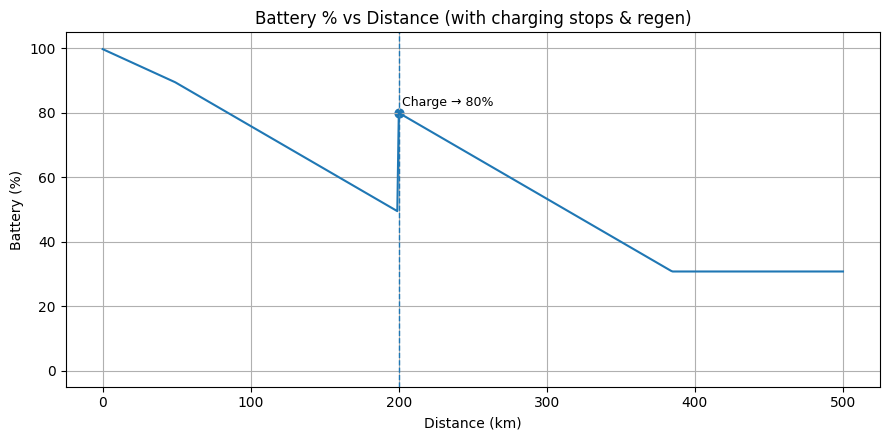

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4.5))
plt.plot(dist_km, battery_percent, label='Battery %')
plt.xlabel("Distance (km)")
plt.ylabel("Battery (%)")
plt.title("Battery % vs Distance (with charging stops & regen)")
plt.grid(True)

# Mark charge stops on the plot
for (stop_km, target_percent) in charge_stops:
    if 0 <= stop_km <= max_distance_km:
        plt.axvline(x=stop_km, linestyle='--', linewidth=1)
        # show a marker at the SOC right after charging
        idx = int(stop_km / step_km)
        soc_after = battery_percent[idx]
        plt.scatter([stop_km], [soc_after], s=40)
        plt.text(stop_km + 2, soc_after + 2, f'Charge → {target_percent}%', fontsize=9)

plt.ylim(-5, 105)
plt.tight_layout()
plt.show()
